In [1]:
import cifar
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from dataclasses import dataclass

In [2]:
# Many of these steps were used from
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html
for ii in range(1, 6):
    print(f"Analyzing videos/vid{ii}_clipped.mp4")
    
    PATH = f"figures/hw4/vid{ii}"
    os.makedirs(PATH, exist_ok = True)
    
    cap = cv.VideoCapture(f"videos/vid{ii}_clipped.mp4")

    # Feature parameters
    feature_params = {
        "maxCorners": 100,
        "qualityLevel": 0.3,
        "minDistance": 7,
        "blockSize": 7 
    }

    # Lucas Kinade parameters
    lk_params = {
        "winSize": (15, 15),
        "maxLevel": 4,
        "criteria": (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
    }

    # Create some random colors
    color = np.random.randint(0,255,(100,3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    # Initialize flag to end viewing when q is pressed
    stop = False
    
    frame_number = 0

    while (not stop):
        ret,frame = cap.read()
        if frame is None:
            print("End of video, breaking")
            break
        
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        if p1 is None: 
            print("Failed to extract features")
            continue

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        try:
            # Draw the tracks
            for i,(new,old) in enumerate(zip(good_new,good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                
                # Set values to integers to allow for drawing
                a = int(a)
                b = int(b)
                c = int(c)
                d = int(d)

                mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                frame = cv.circle(frame, (a,b), 5, color[i].tolist(), -1)
                
            img = cv.add(frame,mask)
            
            cv.imshow('Frame', img)
            # cv.imwrite(os.path.join(PATH, f"vid_{ii}_{frame_number}.png"), img)
            
            frame_number += 1
            
            while True:
                # Exit if 'q' is pressed
                if cv.waitKey(25) & 0xFF == ord('q'):
                    stop = True
                    break
                elif cv.waitKey(33) == 32: break
                                                                     
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1,1,2)
        except Exception as e:
            print(f"Iteration failed: {e}")

    cv.destroyAllWindows()
    cap.release()

Analyzing videos/vid1_clipped.mp4
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
Failed to extract features
End of video, breaking
Analyzing videos/vid2_clipped.mp4
End of video, breaking
Analyzing videos/vid3_clipped.mp4
End of video, breaking
Analyzing videos/vid4_clipped.mp4
End of video, breaking
Analyzing videos/vid5_clipped.mp4
End of video, breaking


In [3]:
@dataclass(frozen = True)
class ImageMetaData():
    rgb: np.ndarray
    filename: str
    img_class: str
    
    @property
    def grayscale(self): 
        return cv.cvtColor(self.rgb, cv.COLOR_RGB2GRAY)

In [4]:
# Pure red/green/blue values
RED_U8 = (255, 0, 0)
GREEN_U8 = (0, 255, 0)
BLUE_U8 = (0, 0, 255)

FIGURE_PATH = "figures/hw4"

os.makedirs(FIGURE_PATH, exist_ok = True)

def figure_path(name: str):
    return os.path.join(FIGURE_PATH, name)

In [5]:
np.random.seed(400)

In [6]:
data = cifar.unpack("data_batch_3")

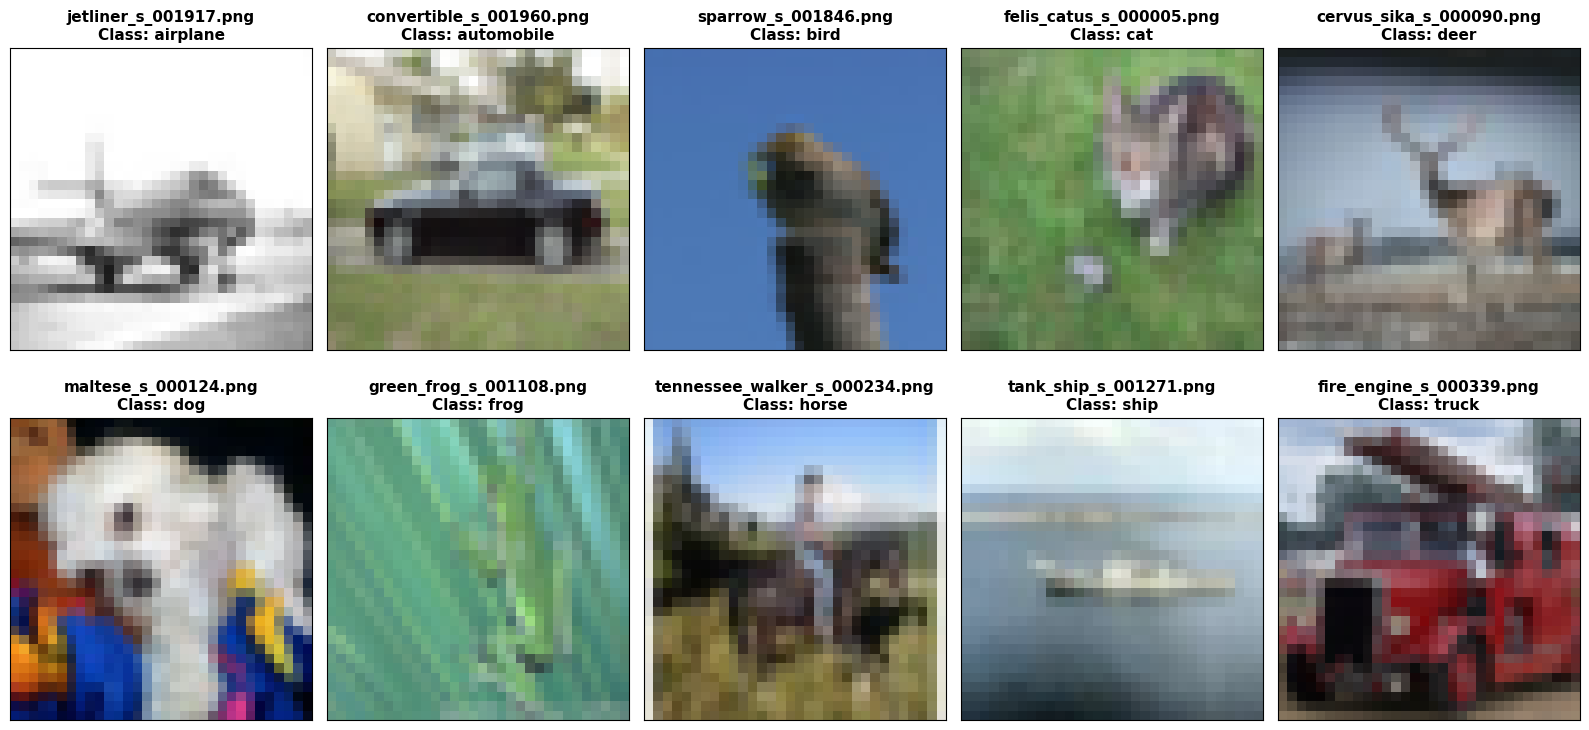

In [7]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax = ax.flatten() # flatten array to iterate with a single loop

# initialize list of image containers
img_data: list[ImageMetaData] = []

for ii in range(10):
    # get images corresponding to a given label
    imgs, names = cifar.get_images_by_label(data, label = ii)
    
    # randomly select an index in the list of images to use as image for a given class
    rand_img_index = np.random.randint(0, len(imgs)-1)
    
    # append image metadata to list to store for remaining HW assignment parts
    img = cifar.data_to_rgb_image(imgs[rand_img_index])
    img_data.append(
        ImageMetaData(
            rgb = img,
            filename = names[rand_img_index],
            img_class = cifar.label_index_to_name(ii)
        )
    )
    
    # visualize image
    ax[ii].imshow(img_data[ii].rgb)
    ax[ii].set_title(f"{img_data[ii].filename}\nClass: {img_data[ii].img_class}", fontsize = 11, fontweight = 'bold')
    
    # remove x/y-ticks from image
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
    ax[ii].set_xticklabels([])
    ax[ii].set_yticklabels([])
    
# save figure
fig.savefig(figure_path("raw_images.png"))

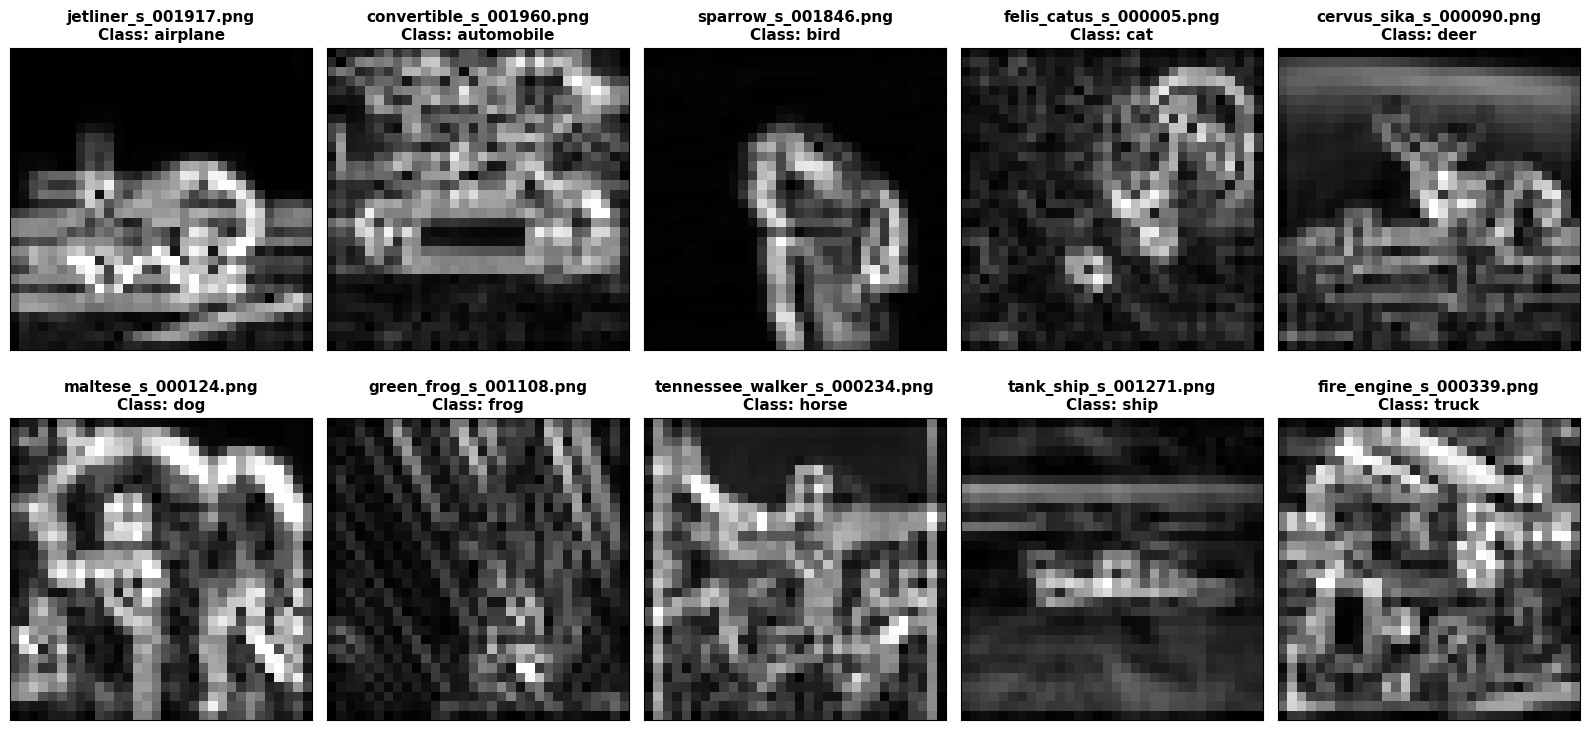

In [8]:
fig, ax = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax = ax.flatten() # flatten array to iterate with a single loops

for ii, img in enumerate(img_data):
    # Take x and y gradients
    grad_x = cv.Sobel(img.grayscale, cv.CV_16S, 1, 0, ksize=3)
    grad_y = cv.Sobel(img.grayscale, cv.CV_16S, 0, 1, ksize=3)

    # Convert data back to unsigned 8-bit integer 
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)

    # Compute weighted sum of x and y gradients
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    ax[ii].imshow(grad, cmap = "gray")
    ax[ii].set_title(f"{img_data[ii].filename}\nClass: {img_data[ii].img_class}", fontsize = 11, fontweight = 'bold')
    
    # remove x/y-ticks from image
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
    ax[ii].set_xticklabels([])
    ax[ii].set_yticklabels([])
    
fig.savefig(figure_path("sobel.png"))

c:\Users\thegr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\thegr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\thegr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\thegr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

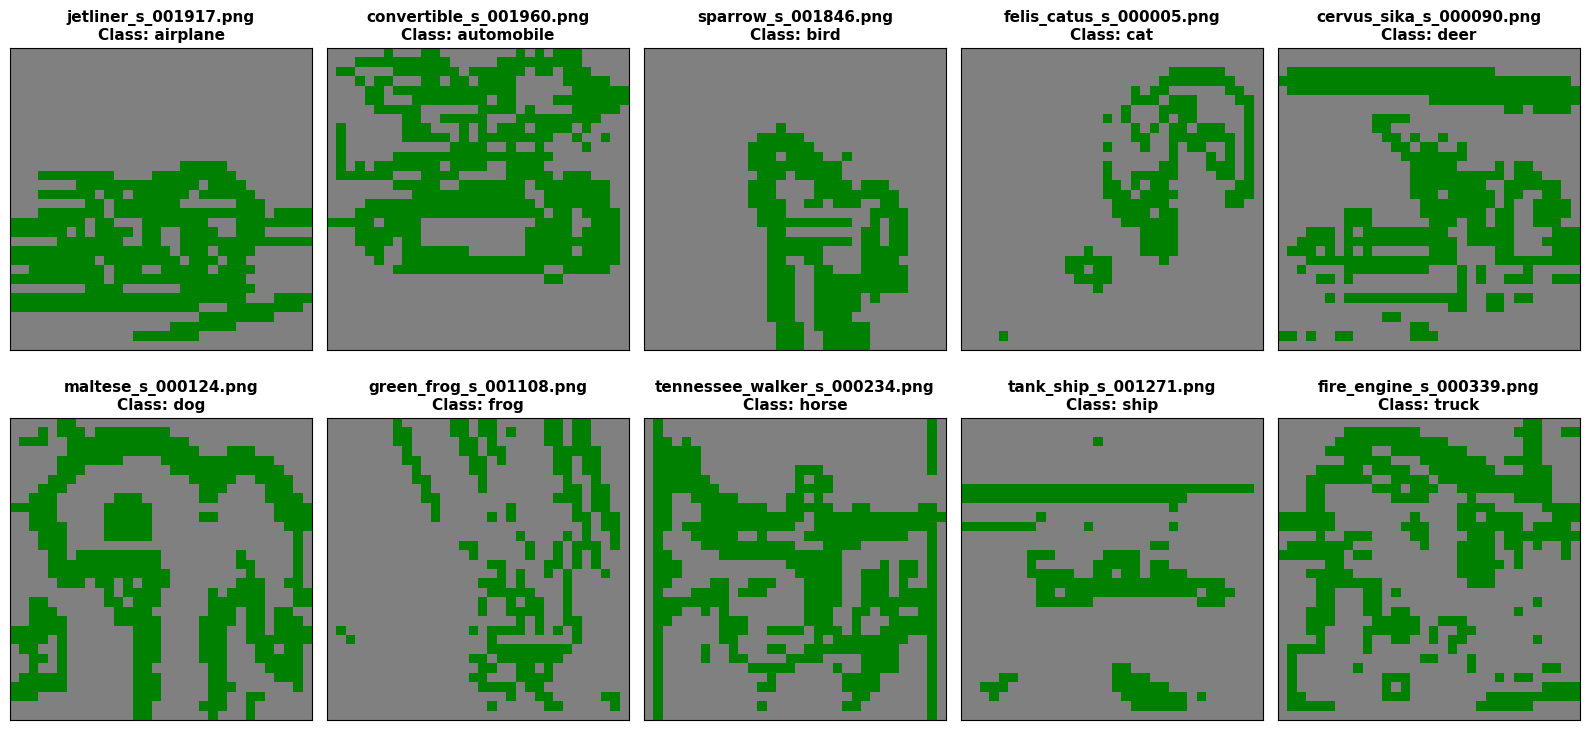

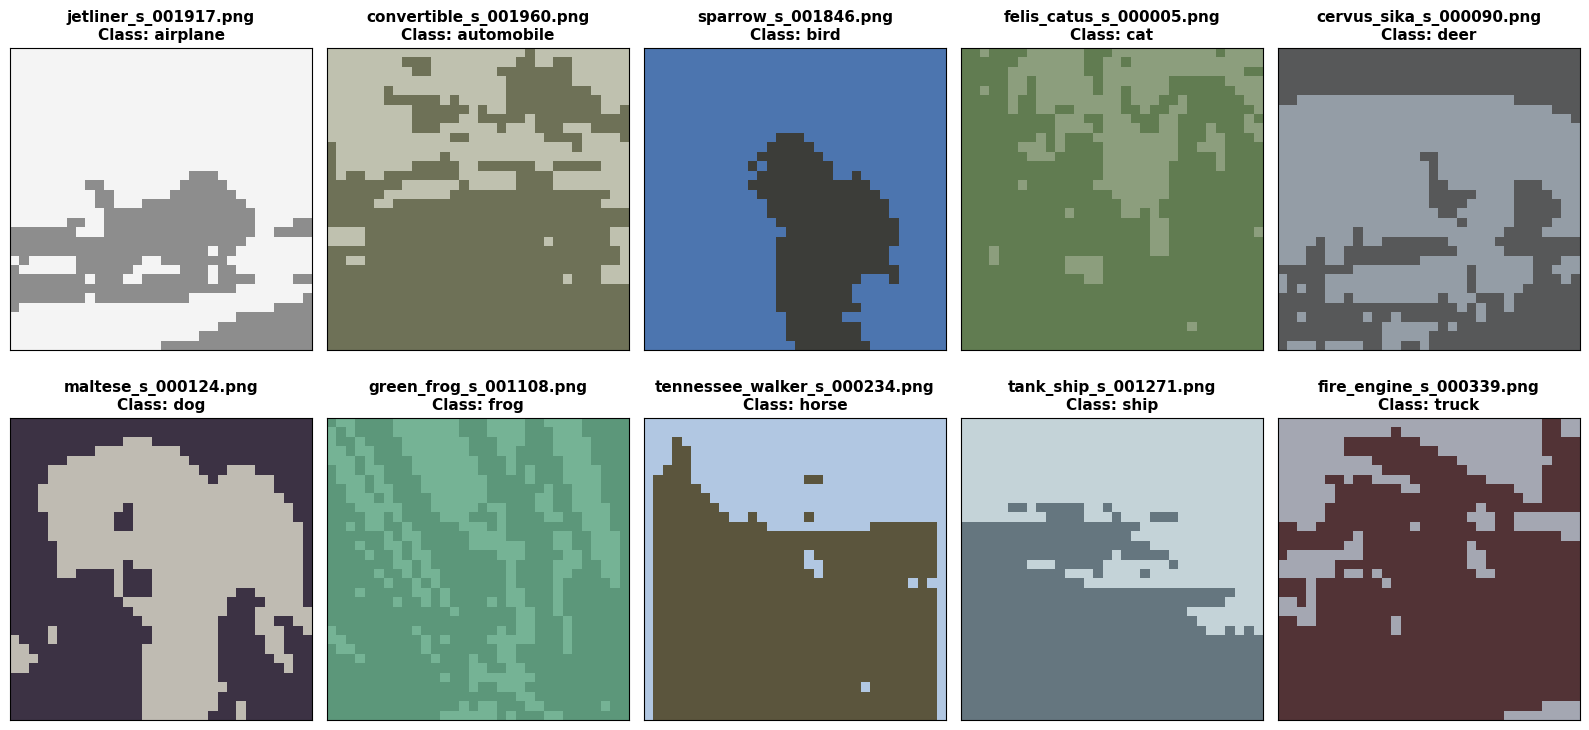

In [9]:
fig1, ax1 = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax1 = ax1.flatten() # flatten array to iterate with a single loops

fig2, ax2 = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax2 = ax2.flatten() # flatten array to iterate with a single loops

for ii, img in enumerate(img_data):
    # Take x and y gradients
    grad_x = cv.Sobel(img.grayscale, cv.CV_16S, 1, 0, ksize=3)
    grad_y = cv.Sobel(img.grayscale, cv.CV_16S, 0, 1, ksize=3)

    # Convert data back to unsigned 8-bit integer 
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)

    # Compute weighted sum of x and y gradients
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    # Perform K-Means w/ n=2 clusters. Reshape image into 1D vector
    k = KMeans(n_clusters = 2)
    k.fit(grad.reshape((cifar.get_image_width() * cifar.get_image_height(), 1)))

    # Get clusters, resize image to original dimensions (just 2D for grayscale)
    im = k.cluster_centers_[k.labels_].reshape(cifar.get_image_size()[:2])
    
    # Repeat for RGB images. Normalize to (0, 1) by dividing by max value (u8: 255). 
    # Include 3 for number of channels in size matrix
    k2 = KMeans(n_clusters = 2)
    k2.fit((img.rgb / 255.0).reshape((cifar.get_image_width() * cifar.get_image_height(), 3)))

    # Get clusters + reshape
    im2 = k2.cluster_centers_[k2.labels_].reshape(cifar.get_image_size())

    for a, image_ in zip([ax1, ax2], [im, im2]):
        a[ii].imshow(image_, cmap = matplotlib.colors.ListedColormap(['gray', 'green']))
        a[ii].set_title(f"{img.filename}\nClass: {img.img_class}", fontsize = 11, fontweight = 'bold')
        
        # remove x/y-ticks from image
        a[ii].set_xticks([])
        a[ii].set_yticks([])
        a[ii].set_xticklabels([])
        a[ii].set_yticklabels([])
    
fig1.savefig(figure_path("kmeans_sobel.png"))
fig2.savefig(figure_path("kmeans_rgb.png"))

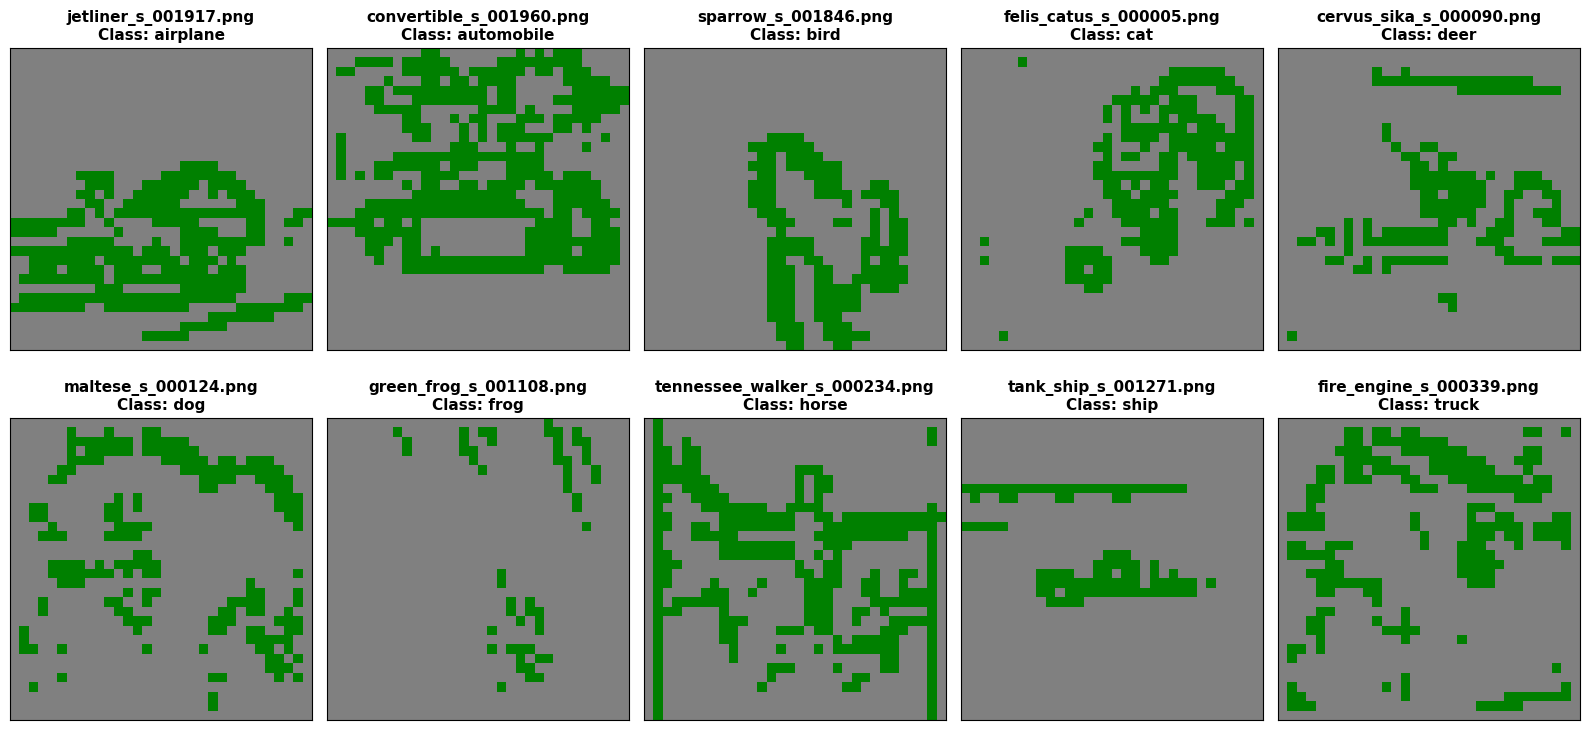

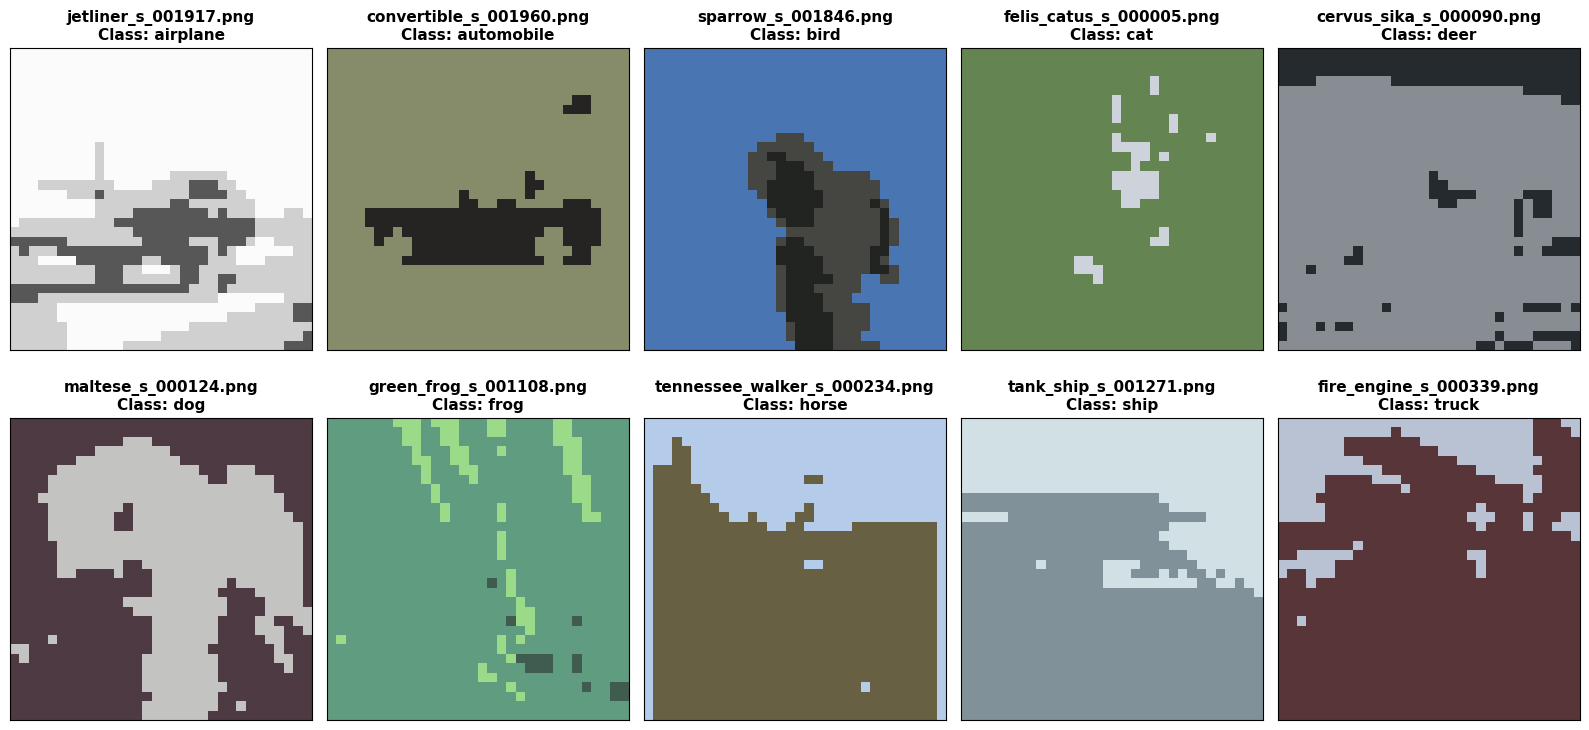

In [10]:
fig1, ax1 = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax1 = ax1.flatten() # flatten array to iterate with a single loops

fig2, ax2 = plt.subplots(2, 5, figsize = (16, 9), tight_layout = True)
ax2 = ax2.flatten() # flatten array to iterate with a single loops

for ii, img in enumerate(img_data):
    # Take x and y gradients
    grad_x = cv.Sobel(img.grayscale, cv.CV_16S, 1, 0, ksize=3)
    grad_y = cv.Sobel(img.grayscale, cv.CV_16S, 0, 1, ksize=3)

    # Convert data back to unsigned 8-bit integer 
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)

    # Compute weighted sum of x and y gradients
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    # Transformation size (Sobel filter)
    dim = (cifar.get_image_width() * cifar.get_image_height(), 1)

    # Estimate bandwidth
    bw = estimate_bandwidth(grad.reshape(dim))

    # Perform mean shift
    ms = MeanShift(bandwidth = bw)
    ms.fit(grad.reshape(dim))

    # Get clusters, resize image to original dimensions (just 2D for grayscale)
    im = ms.cluster_centers_[ms.labels_].reshape(cifar.get_image_size()[:2])

    # Repeat for RGB image
    dim2 = (cifar.get_image_width() * cifar.get_image_height(), 3)
    
    bw2 = estimate_bandwidth((img.rgb / 255.0).reshape(dim2))
    ms2 = MeanShift(bandwidth = bw2)
    ms2.fit((img.rgb / 255.0).reshape(dim2))
    
    # Get clusters + reshape
    im2 = ms2.cluster_centers_[ms2.labels_].reshape(cifar.get_image_size())

    for a, image_ in zip([ax1, ax2], [im, im2]):
        a[ii].imshow(image_, cmap = matplotlib.colors.ListedColormap(['gray', 'green']))
        a[ii].set_title(f"{img.filename}\nClass: {img.img_class}", fontsize = 11, fontweight = 'bold')
        
        # remove x/y-ticks from image
        a[ii].set_xticks([])
        a[ii].set_yticks([])
        a[ii].set_xticklabels([])
        a[ii].set_yticklabels([])
        
fig1.savefig(figure_path("mean_shift_sobel.png"))
fig2.savefig(figure_path("mean_shift_rgb.png"))